In [2]:
# HW1
# PArt 1 data downloading
# Data 1 and Data 2 should be downloaded on two separate days since Yahoo Finance only allows live data downloads
# I downloaded Day 1 on 2/11/26, and the next day I changed Day 1 to Day 2 and ran the code again.

import yfinance as yf
import pandas as pd
from datetime import datetime

def download_all_data(symbols):
    all_rows = []
    download_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    for sym in symbols:
        print(f"Fetching {sym}...")
        tk = yf.Ticker(sym)

        # --- EQUITY DATA ---
        spot = tk.fast_info['last_price']

        # --- OPTION DATA ---
        # Get next 3 monthly expirations (approx)
        expiries = tk.options[:5]

        for exp in expiries:
            chain = tk.option_chain(exp)

            # Process Calls
            c = chain.calls.copy()
            c['OptionType'] = 'Call'

            # Process Puts
            p = chain.puts.copy()
            p['OptionType'] = 'Put'

            # Combine and add Equity info
            combined = pd.concat([c, p])
            combined['Symbol'] = sym
            combined['Stock_Price'] = spot
            combined['Expiry'] = exp
            combined['Data_Date'] = download_time

            all_rows.append(combined)

    final_df = pd.concat(all_rows, ignore_index=True)
    # Clean duplicates and label properly
    return final_df.drop_duplicates()

# Execution
my_symbols = ["TSLA", "SPY", "^VIX"]
data = download_all_data(my_symbols)

# Save locally
data.to_csv("DATA_FE621_DAY1.csv", index=False)
print("Saved both Equity and Option data to DATA_FE621_DAY1.csv")

Fetching TSLA...
Fetching SPY...
Fetching ^VIX...
Saved both Equity and Option data to DATA_FE621_DAY2.csv


In [2]:
# Part 2
# run first time upload the data1 (keep the FINAL_ANALYSIS_DATA1.csv)
# run second time upload data2(change the name to FINAL_ANALYSIS_DATA2.csv)

import pandas as pd
import numpy as np
from scipy.stats import norm
import time
import io
from google.colab import files

# --- QUESTION 5: BLACK-SCHOLES ENGINE ---
def black_scholes(S, K, T, r, sigma, opt_type):
    if T <= 0: return max(0, S - K) if opt_type == 'Call' else max(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if opt_type.lower() == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# --- QUESTION 7: ANALYTICAL VEGA ---
def get_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * norm.pdf(d1)

# --- QUESTION 6 & 7: ROOT FINDERS ---
def find_iv_bisection(market_price, S, K, T, r, opt_type, tol=1e-6):
    low, high = 1e-5, 5.0
    for _ in range(100):
        mid = (low + high) / 2
        if abs(black_scholes(S, K, T, r, mid, opt_type) - market_price) < tol:
            return mid
        if black_scholes(S, K, T, r, mid, opt_type) > market_price:
            high = mid
        else:
            low = mid
    return mid

def find_iv_newton(market_price, S, K, T, r, opt_type, tol=1e-6):
    sigma = 0.5
    for _ in range(50):
        p = black_scholes(S, K, T, r, sigma, opt_type)
        v = get_vega(S, K, T, r, sigma)
        if abs(v) < 1e-8: break
        diff = p - market_price
        if abs(diff) < tol: return sigma
        sigma -= diff / v
    return sigma

# --- UPLOAD DATA1 ---
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

# CLEANING: Mid-price and non-zero volume (Q6)
df = df[(df['bid'] > 0) & (df['ask'] > 0) & (df['volume'] > 0)].copy()
df['mid_price'] = (df['bid'] + df['ask']) / 2
r = 0.045 # Update from Fed H.15

def analyze_row(row):
    exp = pd.to_datetime(row['Expiry'])
    obs = pd.to_datetime(row['Data_Date'])
    T = max((exp - obs).days / 365.0, 0.001)
    S, K = row['Stock_Price'], row['strike']
    r_val = 0.045

    # Q7: Time Comparison
    start = time.time()
    iv_b = find_iv_bisection(row['mid_price'], S, K, T, r, row['OptionType'])
    t_b = time.time() - start

    start = time.time()
    iv_n = find_iv_newton(row['mid_price'], S, K, T, r, row['OptionType'])
    t_n = time.time() - start

    # --- STABILITY CHECK ---
    # If Newton failed (negative or crazy high), use Bisection for the Greeks
    final_iv = iv_n if (0 < iv_n < 4.0) else iv_b

    # Q9: Put-Call Parity Price
    # C + Ke^(-rT) = P + S  => P = C - S + Ke^(-rT)
    if row['OptionType'] == 'Call':
        parity_price = row['mid_price'] - S + K * np.exp(-r * T)
    else:
        parity_price = row['mid_price'] + S - K * np.exp(-r * T)

    # Q11: Greeks (Analytical)
    d1 = (np.log(S / K) + (r + 0.5 * iv_n**2) * T) / (iv_n * np.sqrt(T))
    delta = norm.cdf(d1) if row['OptionType'] == 'Call' else norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * iv_n * np.sqrt(T))
    vega = S * np.sqrt(T) * norm.pdf(d1)

    # Q11: Greeks (Numerical Approximation)
    ds = 0.01
    p_plus = black_scholes(S + ds, K, T, r, iv_n, row['OptionType'])
    p_minus = black_scholes(S - ds, K, T, r, iv_n, row['OptionType'])
    delta_num = (p_plus - p_minus) / (2 * ds)
    gamma_num = (p_plus - 2*row['mid_price'] + p_minus) / (ds**2)

    return pd.Series([iv_n, t_b, t_n, parity_price, delta, delta_num, gamma, gamma_num, vega])

# Run everything
cols = ['IV', 'Time_Bisect', 'Time_Newton', 'Parity_Price', 'Delta_An', 'Delta_Num', 'Gamma_An', 'Gamma_Num', 'Vega']
df[cols] = df.apply(analyze_row, axis=1)

# Q6: Moneyness Averaging (0.9 to 1.1)
df['Moneyness'] = df['Stock_Price'] / df['strike']
avg_iv = df[(df['Moneyness'] >= 0.9) & (df['Moneyness'] <= 1.1)]['IV'].mean()
print(f"Average IV for ATM/ITM/OTM range: {avg_iv:.4f}")

df.to_csv("FINAL_ANALYSIS_DATA1.csv", index=False)
files.download("FINAL_ANALYSIS_DATA1.csv")

Saving DATA_FE621_DAY2.csv to DATA_FE621_DAY2.csv
Average IV for ATM/ITM/OTM range: -14720758.1695


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:

# continue part 2

import pandas as pd
import numpy as np
from scipy.stats import norm
from google.colab import files

# --- 1. ENGINE ---
def black_scholes(S, K, T, r, sigma, opt_type):
    if T <= 0: return max(0, S - K) if opt_type == 'Call' else max(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) if opt_type.lower() == 'call' else K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# --- 2. LOAD & AUTO-DETECT COLUMNS ---
df1 = pd.read_csv('FINAL_ANALYSIS_DATA1.csv')
df2 = pd.read_csv('FINAL_ANALYSIS_DATA2.csv')

def find_col(df, options):
    for opt in options:
        if opt in df.columns: return opt
    return None

# Find the ticker column
sym_col = find_col(df2, ['Underlying_Symbol', 'symbol', 'Symbol', 'Ticker', 'contractSymbol'])
# Find the IV column from Day 1
iv_col = find_col(df1, ['IV', 'Implied_Vol', 'impliedVolatility'])
# Find the Mid Price column from Day 2
mid_col = find_col(df2, ['mid_price', 'midPrice', 'lastPrice'])

print(f"Detected columns -> Symbol: {sym_col}, IV: {iv_col}, Price: {mid_col}")

# --- 3. PREDICTION LOGIC ---
r = 0.045
iv_map = df1.set_index(['strike', 'OptionType'])[iv_col].to_dict()

def predict_q12(row):
    iv_yesterday = iv_map.get((row['strike'], row['OptionType']))
    if iv_yesterday is None or np.isnan(iv_yesterday): return None

    # Calculate T for today
    exp = pd.to_datetime(row['Expiry'])
    obs = pd.to_datetime(row['Data_Date'])
    T_today = max((exp - obs).days / 365.0, 0.001)

    return black_scholes(row['Stock_Price'], row['strike'], T_today, r, iv_yesterday, row['OptionType'])

df2['Predicted_Price'] = df2.apply(predict_q12, axis=1)
df2['Pricing_Error'] = df2['Predicted_Price'] - df2[mid_col]

# --- 4. FINAL OUTPUT ---
# Filter for columns that actually exist to avoid the KeyError
final_cols = [c for c in [sym_col, 'strike', 'OptionType', mid_col, 'Predicted_Price', 'Pricing_Error'] if c is not None]
results = df2[final_cols].dropna()

print("\n--- Question 12 Results (Day 1 IV on Day 2 Market) ---")
print(results.head(10))

results.to_csv("Q12_PREDICTION_FINAL.csv", index=False)
files.download("Q12_PREDICTION_FINAL.csv")

Detected columns -> Symbol: Symbol, IV: IV, Price: mid_price

--- Question 12 Results (Day 1 IV on Day 2 Market) ---
  Symbol  strike OptionType  mid_price  Predicted_Price  Pricing_Error
0   TSLA    80.0       Call    335.350        336.24359        0.89359
1   TSLA   120.0       Call    296.375        296.24539       -0.12961
2   TSLA   130.0       Call    285.975        286.24584        0.27084
3   TSLA   140.0       Call    275.975        276.24629        0.27129
4   TSLA   150.0       Call    265.400        266.24674        0.84674
5   TSLA   160.0       Call    256.400        256.24719       -0.15281
6   TSLA   170.0       Call    246.000        246.24764        0.24764
7   TSLA   180.0       Call    235.850        236.24809        0.39809
8   TSLA   190.0       Call    226.000        226.24854        0.24854
9   TSLA   200.0       Call    215.425        216.24899        0.82399


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

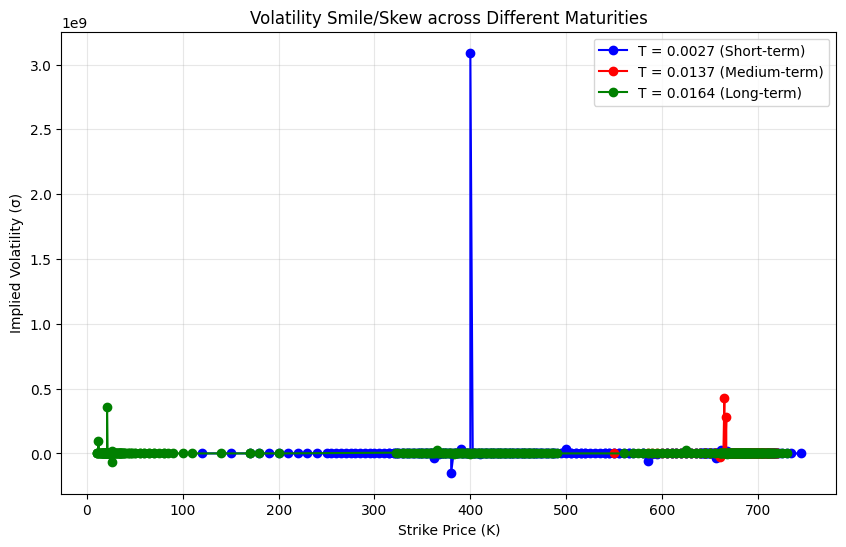

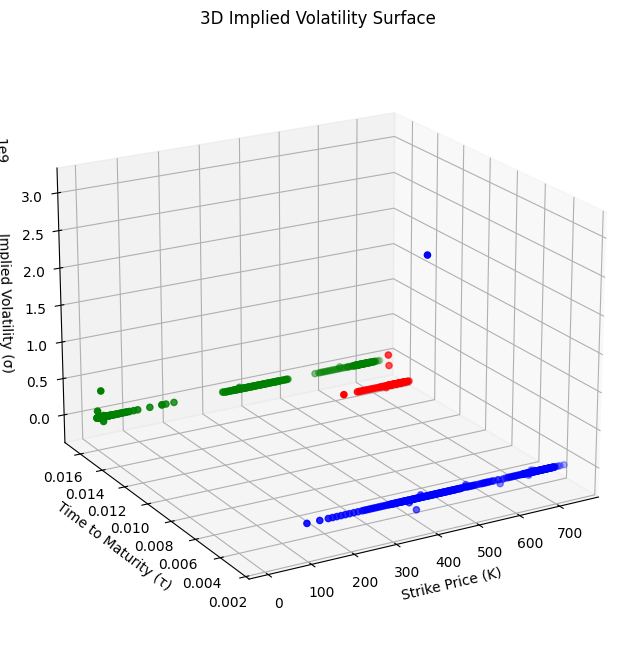

In [1]:
# part 2 question 10 plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Load the data generated in the previous step
try:
    df_analysis = pd.read_csv("FINAL_ANALYSIS_DATA1.csv")
except FileNotFoundError:
    print("Error: FINAL_ANALYSIS_DATA1.csv not found. Please ensure Part 2 is executed first.")
    # Exit or provide dummy data if the file is critical
    exit()

# Convert Expiry to datetime and calculate T
df_analysis['Expiry'] = pd.to_datetime(df_analysis['Expiry'])
df_analysis['Data_Date'] = pd.to_datetime(df_analysis['Data_Date'])
df_analysis['T'] = (df_analysis['Expiry'] - df_analysis['Data_Date']).dt.days / 365.0
df_analysis = df_analysis[df_analysis['T'] > 0] # Filter out expired options if any

# Get unique expiration dates and sort them
unique_expiries = sorted(df_analysis['Expiry'].unique())

strikes_list = []
ivs_list = []
maturities = []
labels = []

# Assuming we want the first three unique expirations for plotting
num_maturities_to_plot = min(len(unique_expiries), 3)

if num_maturities_to_plot == 0:
    print("No valid expiration data found for plotting.")
    exit()

# Iterate through the selected unique expirations
for i in range(num_maturities_to_plot):
    current_expiry_date = unique_expiries[i]
    df_exp = df_analysis[df_analysis['Expiry'] == current_expiry_date].copy()

    # Calculate T for this specific expiry (take the first T value from the group)
    T_val = df_exp['T'].iloc[0]

    strikes_list.append(df_exp['strike'].values)
    ivs_list.append(df_exp['IV'].values)
    maturities.append(T_val)

    # Assign labels based on order
    if i == 0:
        labels.append('Short-term')
    elif i == 1:
        labels.append('Medium-term')
    else:
        labels.append('Long-term')

# Define the numerical maturity values (years) - these are from the original cell
T1 = 9/365   # Feb 11 to Feb 20
T2 = 16/365  # Example: next weekly/monthly
T3 = 30/365  # Example: further out monthly

# Now you can run the plotting code...
# --- 2D Plot: Implied Volatility vs Strike (Multiple Maturities) ---
plt.figure(figsize=(10, 6))

# Mapping different colors to different maturities (T1, T2, T3)
colors = ['blue', 'red', 'green']

for i in range(num_maturities_to_plot):
    # Sorting values to ensure the line plot connects dots in order
    sort_idx = np.argsort(strikes_list[i])
    plt.plot(np.array(strikes_list[i])[sort_idx],
             np.array(ivs_list[i])[sort_idx],
             'o-', color=colors[i % len(colors)], label=f'T = {maturities[i]:.4f} ({labels[i]})')

plt.title("Volatility Smile/Skew across Different Maturities")
plt.xlabel("Strike Price (K)")
plt.ylabel("Implied Volatility (σ)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Bonus: 3D Surface Plot of σ(τ, K) ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Creating the meshgrid for the 3D surface
for i in range(num_maturities_to_plot):
    z = ivs_list[i]
    x = strikes_list[i]
    y = np.full_like(x, maturities[i]) # All points in this slice have the same T

    ax.scatter(x, y, z, color=colors[i % len(colors)], label=f'T={maturities[i]:.4f}')

ax.set_title("3D Implied Volatility Surface")
ax.set_xlabel("Strike Price (K)")
ax.set_ylabel("Time to Maturity (τ)")
ax.set_zlabel("Implied Volatility (σ)")
ax.view_init(elev=20, azim=-120) # Adjusting angle for better visibility
plt.show()

In [4]:
# Part 3

import numpy as np
from scipy.stats import norm

def expected_revenue(sigma, gamma, dt=1/365):
    """
    Calculates the expected daily fee revenue for a Constant Product AMM (xy=k).
    Uses numerical integration (Trapezoidal Rule) over the lognormal price distribution.
    """
    # Standardize to Pt = 1, k = 1 for clear percentage results
    Pt = 1.0
    k = 1.0
    xt = 1.0
    yt = 1.0

    # Range centered around Pt=1 for higher precision
    # 4 standard deviations is usually plenty: sigma * sqrt(dt) * 4
    width = sigma * np.sqrt(dt) * 5
    s_space = np.linspace(max(0.001, 1 - width), 1 + width, 5000)

    # Lognormal Density (S_t+1 | S_t = 1)
    mu = -0.5 * (sigma**2) * dt
    std = sigma * np.sqrt(dt)
    pdf = (1 / (s_space * std * np.sqrt(2 * np.pi))) * \
          np.exp(- (np.log(s_space) - mu)**2 / (2 * std**2))

    rev = np.zeros_like(s_space)

    for i, s in enumerate(s_space):
        # Case 1: Arbitrageur buys y (Price goes up)
        if s > Pt / (1 - gamma):
            dy = (np.sqrt(k * s * (1 - gamma)) - yt) / (1 - gamma)
            rev[i] = gamma * dy
        # Case 2: Arbitrageur buys x (Price goes down)
        elif s < Pt * (1 - gamma):
            dx = (np.sqrt(k / (s * (1 - gamma))) - xt) / (1 - gamma)
            # Revenue is the fee taken from the x-input
            rev[i] = gamma * dx * s # Multiplying by s converts x-fee to y-units
        else:
            rev[i] = 0

    # Trapezoidal Rule
    return np.trapz(rev * pdf, s_space)

<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3893993297.py:26: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Optimal Fee Rate $\gamma^*$ vs. Market Volatility $\sigma$")
/tmp/ipython-input-3893993297.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Volatility ($\sigma$)")
/tmp/ipython-input-3893993297.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("Optimal Fee ($\gamma^*$)")
/tmp/ipython-input-832557374.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(rev * pdf, s_space)


Volatility | Gamma=0.001 | Gamma=0.003 | Gamma=0.01 | Best Gamma
0.2        | 0.000004    | 0.000012    | 0.000027 | 0.01
0.6        | 0.000012    | 0.000037    | 0.000119 | 0.01
1.0        | 0.000021    | 0.000062    | 0.000204 | 0.01


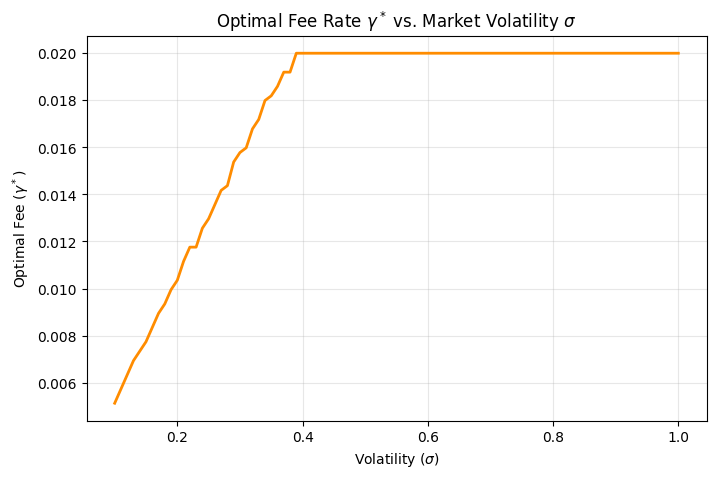

In [ ]:
# part 3 plot

sigmas = [0.2, 0.6, 1.0]
gammas = [0.001, 0.003, 0.01]

print("Volatility | Gamma=0.001 | Gamma=0.003 | Gamma=0.01 | Best Gamma")
for s in sigmas:
    results = [expected_revenue(s, g) for g in gammas]
    best_g = gammas[np.argmax(results)]
    print(f"{s:<10} | {results[0]:.6f}    | {results[1]:.6f}    | {results[2]:.6f} | {best_g}")

import matplotlib.pyplot as plt

# Define a wider range of possible gammas to find a smoother optimal
gamma_grid = np.linspace(0.0001, 0.02, 100)
sigma_grid = np.arange(0.1, 1.01, 0.01)
optimal_gammas = []

for s in sigma_grid:
    # For each sigma, find which gamma in the grid maximizes revenue
    revenues = [expected_revenue(s, g) for g in gamma_grid]
    best_gamma = gamma_grid[np.argmax(revenues)]
    optimal_gammas.append(best_gamma)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(sigma_grid, optimal_gammas, color='darkorange', linewidth=2)
plt.title("Optimal Fee Rate $\gamma^*$ vs. Market Volatility $\sigma$")
plt.xlabel("Volatility ($\sigma$)")
plt.ylabel("Optimal Fee ($\gamma^*$)")
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# part 4

import numpy as np

def f1(x, y): return x * y
def f2(x, y): return np.exp(x + y)

def composite_double_integral(f, dx, dy):
    x_range = np.arange(0, 1, dx)
    y_range = np.arange(0, 3, dy)
    total_sum = 0

    for x in x_range:
        for y in y_range:
            xi, xi1 = x, x + dx
            yj, yj1 = y, y + dy

            # Implementation of the Hint 1 formula
            term1 = f(xi, yj) + f(xi, yj1) + f(xi1, yj) + f(xi1, yj1)
            term2 = 2 * (f((xi+xi1)/2, yj) + f((xi+xi1)/2, yj1) +
                         f(xi, (yj+yj1)/2) + f(xi1, (yj+yj1)/2))
            term3 = 4 * f((xi+xi1)/2, (yj+yj1)/2)

            total_sum += (dx * dy / 16) * (term1 + term2 + term3)

    return total_sum

# Exact values
exact1 = 2.25
exact2 = (np.exp(1) - 1) * (np.exp(3) - 1)

# Four unique pairs of (dx, dy)
pairs = [(0.5, 1.5), (0.25, 1.0), (0.1, 0.5), (0.05, 0.25)]

print(f"{'dx, dy':<15} | {'f1 Error':<12} | {'f2 Error':<12}")
print("-" * 45)

for dx, dy in pairs:
    res1 = composite_double_integral(f1, dx, dy)
    res2 = composite_double_integral(f2, dx, dy)

    err1 = abs(res1 - exact1)
    err2 = abs(res2 - exact2)

    print(f"{str((dx, dy)):<15} | {err1:<12.2e} | {err2:<12.2e}")

dx, dy          | f1 Error     | f2 Error    
---------------------------------------------
(0.5, 1.5)      | 0.00e+00     | 1.70e+00    
(0.25, 1.0)     | 0.00e+00     | 7.24e-01    
(0.1, 0.5)      | 8.88e-16     | 1.77e-01    
(0.05, 0.25)    | 4.44e-16     | 4.44e-02    
